In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('brown')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import Counter
import string
string.punctuation
import re
from textblob import TextBlob
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/bank_reviews3.csv', encoding='ISO-8859-1')
df.head()

,author,date,address,bank,rating,review_title_by_user,review,bank_image,rating_title_by_user,useful_count
0,AMRENDRA T,"Mar 21, 2020",New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,https://static.bankbazaar.com/images/common/ba...,Great!,133
1,BISHWA,"Mar 20, 2020",Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,89
2,SANTOSH,"Mar 20, 2020",Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,48
3,MAHADEV,"Mar 20, 2020",Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,52
4,R,"Mar 20, 2020",Bangalore,review,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,22


### DATA PREPROCESSING

In [4]:
df.shape

(1000, 10)

In [5]:
df.dtypes

,0
author,object
date,object
address,object
bank,object
rating,float64
review_title_by_user,object
review,object
bank_image,object
rating_title_by_user,object
useful_count,int64


In [6]:
df = df.drop(columns=['author','bank_image','review_title_by_user','rating_title_by_user'])

In [7]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [8]:
df.dtypes

,0
date,datetime64[ns]
address,object
bank,object
rating,float64
review,object
useful_count,int64


In [10]:
df.duplicated().sum()

1

In [11]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [12]:
df.shape

(999, 6)

In [13]:
df["review"].duplicated().sum()

0

In [14]:
df.columns = ['Date','Address','Bank','Rating', 'Review','Useful_Count']
df.head()

,Date,Address,Bank,Rating,Review,Useful_Count
0,2020-03-21,New delhi,SBI,4.0,State Bank Of India is located nearby in our a...,133
1,2020-03-20,Kolkata,SBI,5.0,"I have my salary account in SBI, when I applie...",89
2,2020-03-20,Hooghly,Axis Bank,5.0,I am using Axis bank saving account for the p...,48
3,2020-03-20,Pune,HDFC Bank,5.0,I have my salary bank account in HDFC bank for...,52
4,2020-03-20,Bangalore,review,5.0,"Close to around 10 years, I am holding this Co...",22


In [15]:
def rating_to_sentiment(r):
    if r >= 4:
        return 1
    elif r == 3:
        return 0
    else:
        return -1

df['Polarity'] = df['Rating'].apply(rating_to_sentiment)

In [16]:
value_counts=df.Polarity.value_counts()
value_counts

,count
Polarity,
1,852
-1,77
0,70


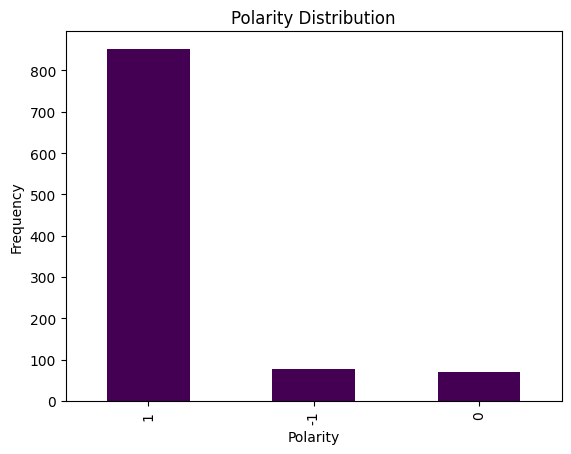

In [17]:
value_counts.plot(kind="bar", colormap='viridis')
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.title("Polarity Distribution")
plt.show()

In [18]:
df.isnull().sum()

,0
Date,0
Address,0
Bank,0
Rating,0
Review,0
Useful_Count,0
Polarity,0


In [19]:
df.reset_index(drop=True, inplace=True)
df.info()

df_og = df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          999 non-null    datetime64[ns]
 1   Address       999 non-null    object        
 2   Bank          999 non-null    object        
 3   Rating        999 non-null    float64       
 4   Review        999 non-null    object        
 5   Useful_Count  999 non-null    int64         
 6   Polarity      999 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 54.8+ KB


### DATA CLEANING

In [20]:
def lower(text):
    words = text.split()
    lower = [word.lower() for word in words]
    return ' '.join(lower)

df['Review']= df['Review'].apply(lambda x:lower(x))

print("Converted all the reviews to lower case ")
df.head()

Converted all the reviews to lower case 


,Date,Address,Bank,Rating,Review,Useful_Count,Polarity
0,2020-03-21,New delhi,SBI,4.0,state bank of india is located nearby in our a...,133,1
1,2020-03-20,Kolkata,SBI,5.0,"i have my salary account in sbi, when i applie...",89,1
2,2020-03-20,Hooghly,Axis Bank,5.0,i am using axis bank saving account for the pa...,48,1
3,2020-03-20,Pune,HDFC Bank,5.0,i have my salary bank account in hdfc bank for...,52,1
4,2020-03-20,Bangalore,review,5.0,"close to around 10 years, i am holding this co...",22,1


In [21]:
link_removed = 0

def hyperlinks(text):
    global link_removed
    pattern = r'http\S+|www\S+'
    matches = re.findall(pattern , text)
    link_removed += len(matches)
    removed = re.sub(pattern, '', text)
    return removed

df['Review']= df['Review'].apply(lambda x:hyperlinks(x))
print(f"successfully removed {link_removed} hyperlinks")

successfully removed 0 hyperlinks


In [22]:
large_spaces = 0
def remove_large_spaces(text):
    global large_spaces
    pattern = r'\s{2,}'
    matches = re.findall(pattern, text)
    large_spaces += len(matches)
    removed_spaces = re.sub(pattern, ' ', text)
    return removed_spaces.strip()
df['Review']= df['Review'].apply(lambda x:remove_large_spaces(x))
print(f"successfully removed {large_spaces} large spaces")

successfully removed 0 large spaces


In [23]:
stopword = set(nltk.corpus.stopwords.words('english'))
print("total stopwords : ", len(stopword))
print(stopword)

total stopwords :  198
{'y', 'if', 't', 'own', 'the', 'hadn', "we'll", 'where', "they'd", 'doing', 'me', 'out', "we're", 'some', 'm', 'ma', 'during', 'that', 'am', "didn't", 'each', 'he', "hasn't", 'they', 'now', 'through', 'couldn', 'were', "i've", 'my', 'between', "shan't", 'more', "don't", 'nor', 'ourselves', 'just', 'can', "he'd", 'against', 'our', 'needn', 'when', 'by', "weren't", 'do', "she'd", 'having', 'such', 'your', 'being', 'both', "couldn't", 'isn', 'those', 'yours', 'don', 'been', "you've", 'had', 'haven', 'o', 'than', 'does', 'same', 'myself', 'most', 'himself', 'mustn', 'with', 'then', 'which', 'll', 'doesn', 'yourself', 'these', 'very', 'shouldn', 'for', "mustn't", "it'd", 'what', "we'd", "it's", 'wouldn', "shouldn't", 'but', 'ain', 'so', 'it', 'above', 'a', 'she', 'why', "she's", 'herself', 'at', "won't", 'no', 'before', 'about', 'further', 'did', 'didn', 'in', 'here', "it'll", "should've", 'up', 'down', 'whom', 'are', 're', "wasn't", "you'll", "you're", 'be', 'few', "

In [24]:
stopword_count = 0

def remove_stopwords(text):
    global stopword_count
    words = text.split()
    filtered_words = [word for word in words if word not in stopword]
    stopword_count += len(words) - len(filtered_words)
    return ' '.join(filtered_words)

df['Review'] = df['Review'].astype(str).apply(remove_stopwords)

print(f"Successfully removed {stopword_count} stopwords")

Successfully removed 27192 stopwords


In [25]:
punctuation_count = 0

def remove_punctuation(text):
    global punctuation_count
    punctuationfree = []
    for char in text:
        if char in string.punctuation:
            punctuation_count += 1
        else:
            punctuationfree.append(char)
    return ''.join(punctuationfree)


df['Review'] = df['Review'].astype(str).apply(remove_punctuation)
print(f"Successfully removed {punctuation_count} punctuation")

Successfully removed 5975 punctuation


In [26]:
import re
number_count = 0

def remove_numbers(text):
    global number_count
    matches = re.findall(r'\d+', text)
    number_count += sum(len(match) for match in matches)
    removed_numbers = re.sub(r'\d+', '', text)
    return removed_numbers

df['Review'] = df['Review'].astype(str).apply(remove_numbers)

print(f"Successfully removed numbers. Total digits removed: {number_count}")

Successfully removed numbers. Total digits removed: 3053


In [27]:
def remove_html(text):
    html_re = re.compile(r'<.*?>')
    text = re.sub(html_re, '', text)
    return text
df['Review']= df['Review'].apply(lambda x:remove_html(x))
print("successfully removed html tags")

successfully removed html tags


In [28]:
date_count = 0
time_count = 0

def remove_date_time(text):
    global date_count, time_count

    # Match MM/DD/YYYY or MM/DD/YY
    date_pattern = r"\b\d{1,2}/\d{1,2}/\d{2,4}\b"
    # Match HH:MM or HH:MMAM / HH:MMPM (optional AM/PM)
    time_pattern = r"\b\d{1,2}:\d{2}(?:[AP]M)?\b"

    dates = re.findall(date_pattern, text)
    times = re.findall(time_pattern, text)
    date_count += len(dates)
    time_count += len(times)

    text_without_date = re.sub(date_pattern, '', text)
    text_without_date_time = re.sub(time_pattern, '', text_without_date)
    return text_without_date_time.strip()

df['Review'] = df['Review'].astype(str).apply(remove_date_time)

print(f"Successfully removed date and time.")
print(f"Total date patterns removed: {date_count}")
print(f"Total time patterns removed: {time_count}")

Successfully removed date and time.
Total date patterns removed: 0
Total time patterns removed: 0


In [29]:
mention_count = 0
hashtag_count = 0

def remove_mentions_hashtags(text):
    global mention_count, hashtag_count

    mentions = re.findall(r"@\w+", text)
    mention_count += len(mentions)
    text = re.sub(r"@\w+", "", text)
    hashtags = re.findall(r"#\w+", text)
    hashtag_count += len(hashtags)
    text = re.sub(r"#\w+", "", text)
    return text.strip()

df['Review'] = df['Review'].astype(str).apply(remove_mentions_hashtags)

print("Successfully removed mentions and hashtags.")
print(f"Mentions removed: {mention_count}")
print(f"Hashtags removed: {hashtag_count}")

Successfully removed mentions and hashtags.
Mentions removed: 0
Hashtags removed: 0


In [30]:
stemmed_word_changes = 0

def stem_text(text):
    global stemmed_word_changes
    stemmer = PorterStemmer()
    words = text.split()
    stemmed_words = []

    for word in words:
        stemmed_word = stemmer.stem(word)
        if stemmed_word != word:
            stemmed_word_changes += 1
        stemmed_words.append(stemmed_word)

    return ' '.join(stemmed_words)

df['Review'] = df['Review'].astype(str).apply(stem_text)

print("Successfully stemmed the text.")
print(f"Total words changed after stemming: {stemmed_word_changes}")

Successfully stemmed the text.
Total words changed after stemming: 14131


In [31]:
def tokenize_data(data):
    tokens = word_tokenize(data)
    return tokens

df['Review']= df['Review'].apply(lambda x:tokenize_data(x))
print("successfully tokenized the text")

successfully tokenized the text


In [32]:
df

,Date,Address,Bank,Rating,Review,Useful_Count,Polarity
0,2020-03-21,New delhi,SBI,4.0,"[state, bank, india, locat, nearbi, area, open...",133,1
1,2020-03-20,Kolkata,SBI,5.0,"[salari, account, sbi, appli, card, got, state...",89,1
2,2020-03-20,Hooghly,Axis Bank,5.0,"[use, axi, bank, save, account, past, year, ea...",48,1
3,2020-03-20,Pune,HDFC Bank,5.0,"[salari, bank, account, hdfc, bank, mani, year...",52,1
4,2020-03-20,Bangalore,review,5.0,"[close, around, year, hold, corpor, bank, save...",22,1
...,...,...,...,...,...,...,...
994,2019-11-26,Ernakulam,review,3.5,"[hold, save, account, feder, bank, charg, rs, ...",3,-1
995,2019-11-26,Ernakulam,Axis Bank,4.0,"[mandatori, balanc, keep, axi, bank, interest,...",0,1
996,2019-11-26,Bangalore,Axis Bank,4.0,"[axi, bank, everi, month, charg, around, rs, c...",0,1
997,2019-11-26,Hyderabad,Axis Bank,5.0,"[salari, account, axi, bank, hold, account, la...",0,1


### EDA

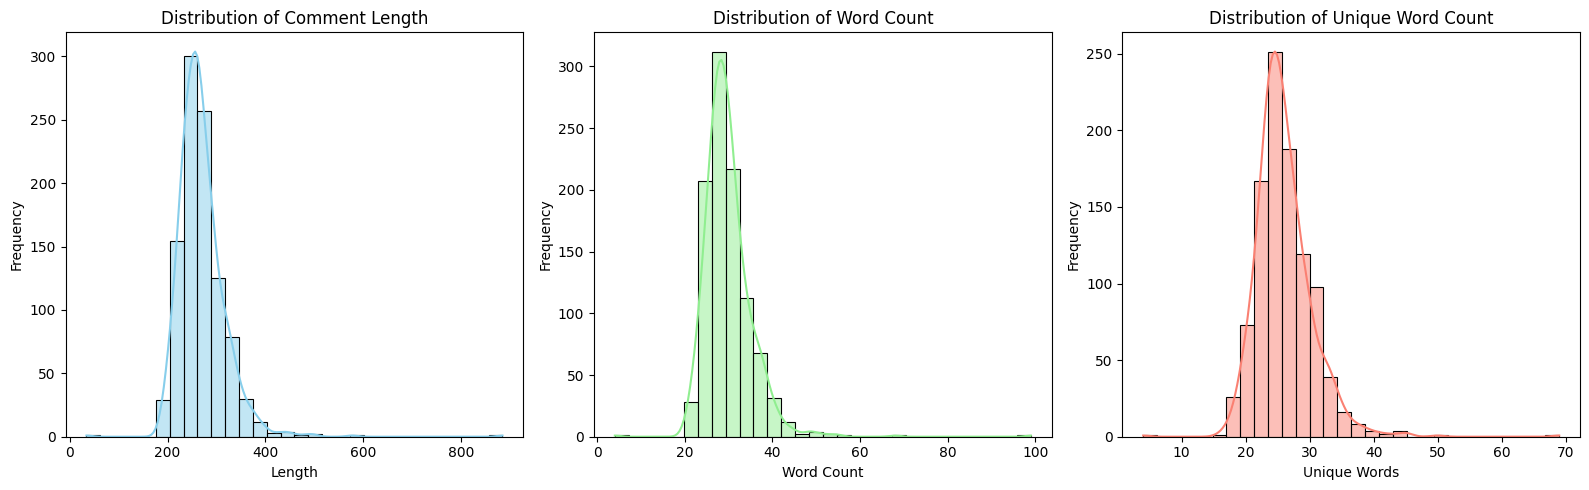

In [33]:
# Basic text statistics
df['comment_length'] = df['Review'].dropna().astype(str).apply(len)
df['word_count'] = df['Review'].dropna().astype(str).apply(lambda x: len(x.split()))
df['unique_word_count'] = df['Review'].dropna().astype(str).apply(lambda x: len(set(x.split())))

# Histograms
plt.figure(figsize=(16, 5))

# Comment length
plt.subplot(1, 3, 1)
sns.histplot(df['comment_length'], bins=30, color='skyblue', kde=True)
plt.title('Distribution of Comment Length')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Word count
plt.subplot(1, 3, 2)
sns.histplot(df['word_count'], bins=30, color='lightgreen', kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Unique word count
plt.subplot(1, 3, 3)
sns.histplot(df['unique_word_count'], bins=30, color='salmon', kde=True)
plt.title('Distribution of Unique Word Count')
plt.xlabel('Unique Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

/tmp/ipython-input-34-751916772.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Rating'], y=df['comment_length'], palette='Blues')
/tmp/ipython-input-34-751916772.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Rating'], y=df['word_count'], palette='Greens')
/tmp/ipython-input-34-751916772.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Rating'], y=df['unique_word_count'], palette='Reds')


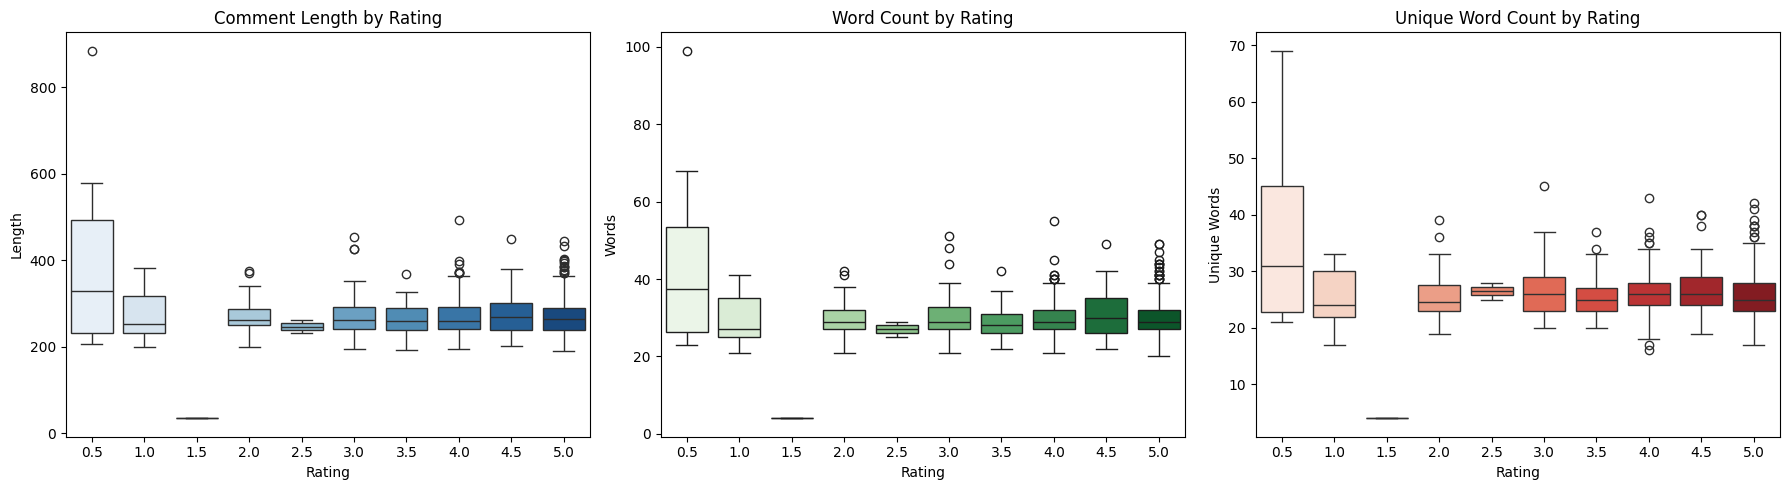

In [34]:
# Boxplots: comment stats vs. rating
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=df['Rating'], y=df['comment_length'], palette='Blues')
plt.title('Comment Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Length')

plt.subplot(1, 3, 2)
sns.boxplot(x=df['Rating'], y=df['word_count'], palette='Greens')
plt.title('Word Count by Rating')
plt.xlabel('Rating')
plt.ylabel('Words')

plt.subplot(1, 3, 3)
sns.boxplot(x=df['Rating'], y=df['unique_word_count'], palette='Reds')
plt.title('Unique Word Count by Rating')
plt.xlabel('Rating')
plt.ylabel('Unique Words')

plt.tight_layout()
plt.show()

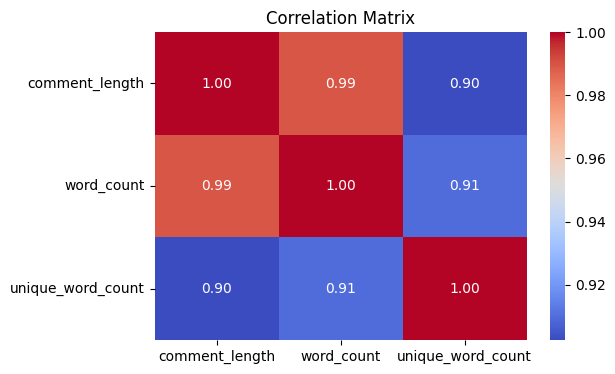

In [35]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
corr = df[['comment_length', 'word_count', 'unique_word_count']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [36]:
# Per-rating average stats
rating_stats = df.groupby('Rating')[['comment_length', 'word_count', 'unique_word_count']].mean().round(1)
print("Average Comment Stats by Rating:")
rating_stats

Average Comment Stats by Rating:


,comment_length,word_count,unique_word_count
Rating,,,
0.5,399.1,44.9,36.1
1.0,269.3,29.4,25.5
1.5,34.0,4.0,4.0
2.0,270.4,29.7,25.6
2.5,246.5,27.0,26.5
3.0,271.9,30.2,26.6
3.5,265.5,29.4,25.6
4.0,268.3,29.7,26.0
4.5,278.1,30.8,26.8


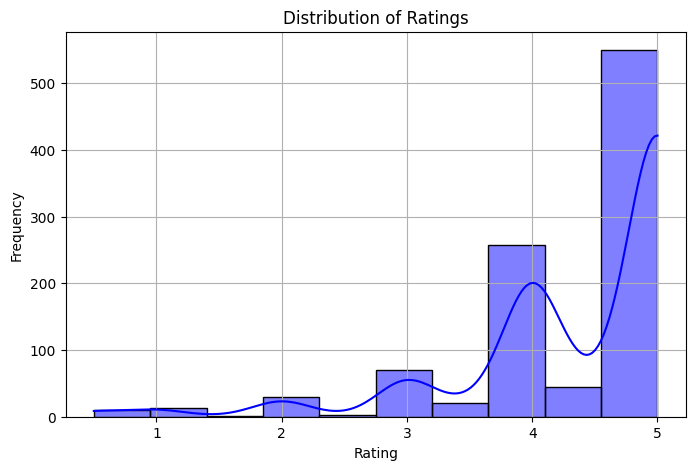

In [37]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=10, kde=True, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

/tmp/ipython-input-38-4085733859.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='pastel')


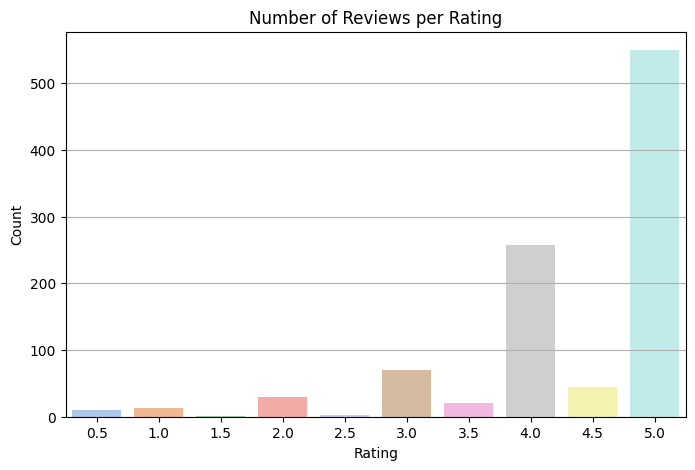

In [38]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=df, palette='pastel')
plt.title('Number of Reviews per Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

In [39]:
df.columns

Index(['Date', 'Address', 'Bank', 'Rating', 'Review', 'Useful_Count',
       'Polarity', 'comment_length', 'word_count', 'unique_word_count'],
      dtype='object')

Polarity    -1   0    1
year_month             
2019-11      3   4   36
2019-12     25  19  226
2020-01     25  18  245
2020-02     15  13  177
2020-03      9  16  168


<Figure size 1200x600 with 0 Axes>

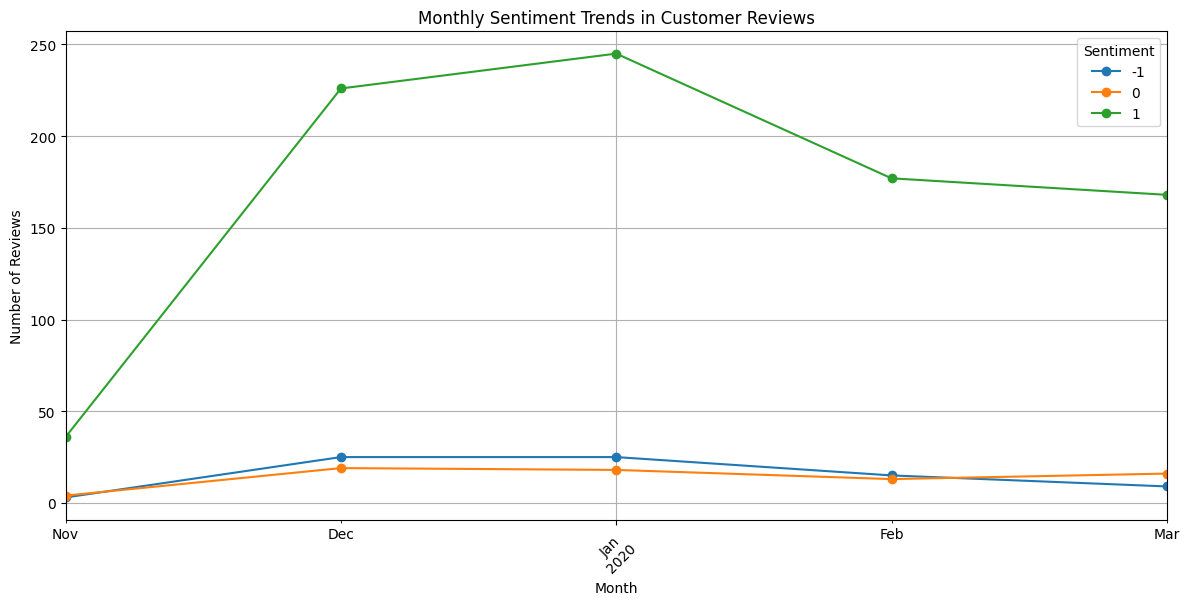

In [40]:
df['year_month'] = df['Date'].dt.to_period('M')

monthly_sentiment_counts = df.groupby(['year_month', 'Polarity']).size().unstack(fill_value=0)

print(monthly_sentiment_counts.tail())

plt.figure(figsize=(12, 6))
monthly_sentiment_counts.plot(kind='line', marker='o', figsize=(12, 6))

plt.title('Monthly Sentiment Trends in Customer Reviews')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Polarity       -1   0   1
Address                  
Agartala        0   0   2
Agra            0   0   1
Ahmedabad       0   0   9
Ajmer           0   0   1
Allahabad       0   0   2
...            ..  ..  ..
Vadodara        0   0   2
Vijayawada      0   0   3
Visakhapatnam   0   0   7
Vizianagaram    0   0   3
Warangal        0   1   5

[107 rows x 3 columns]


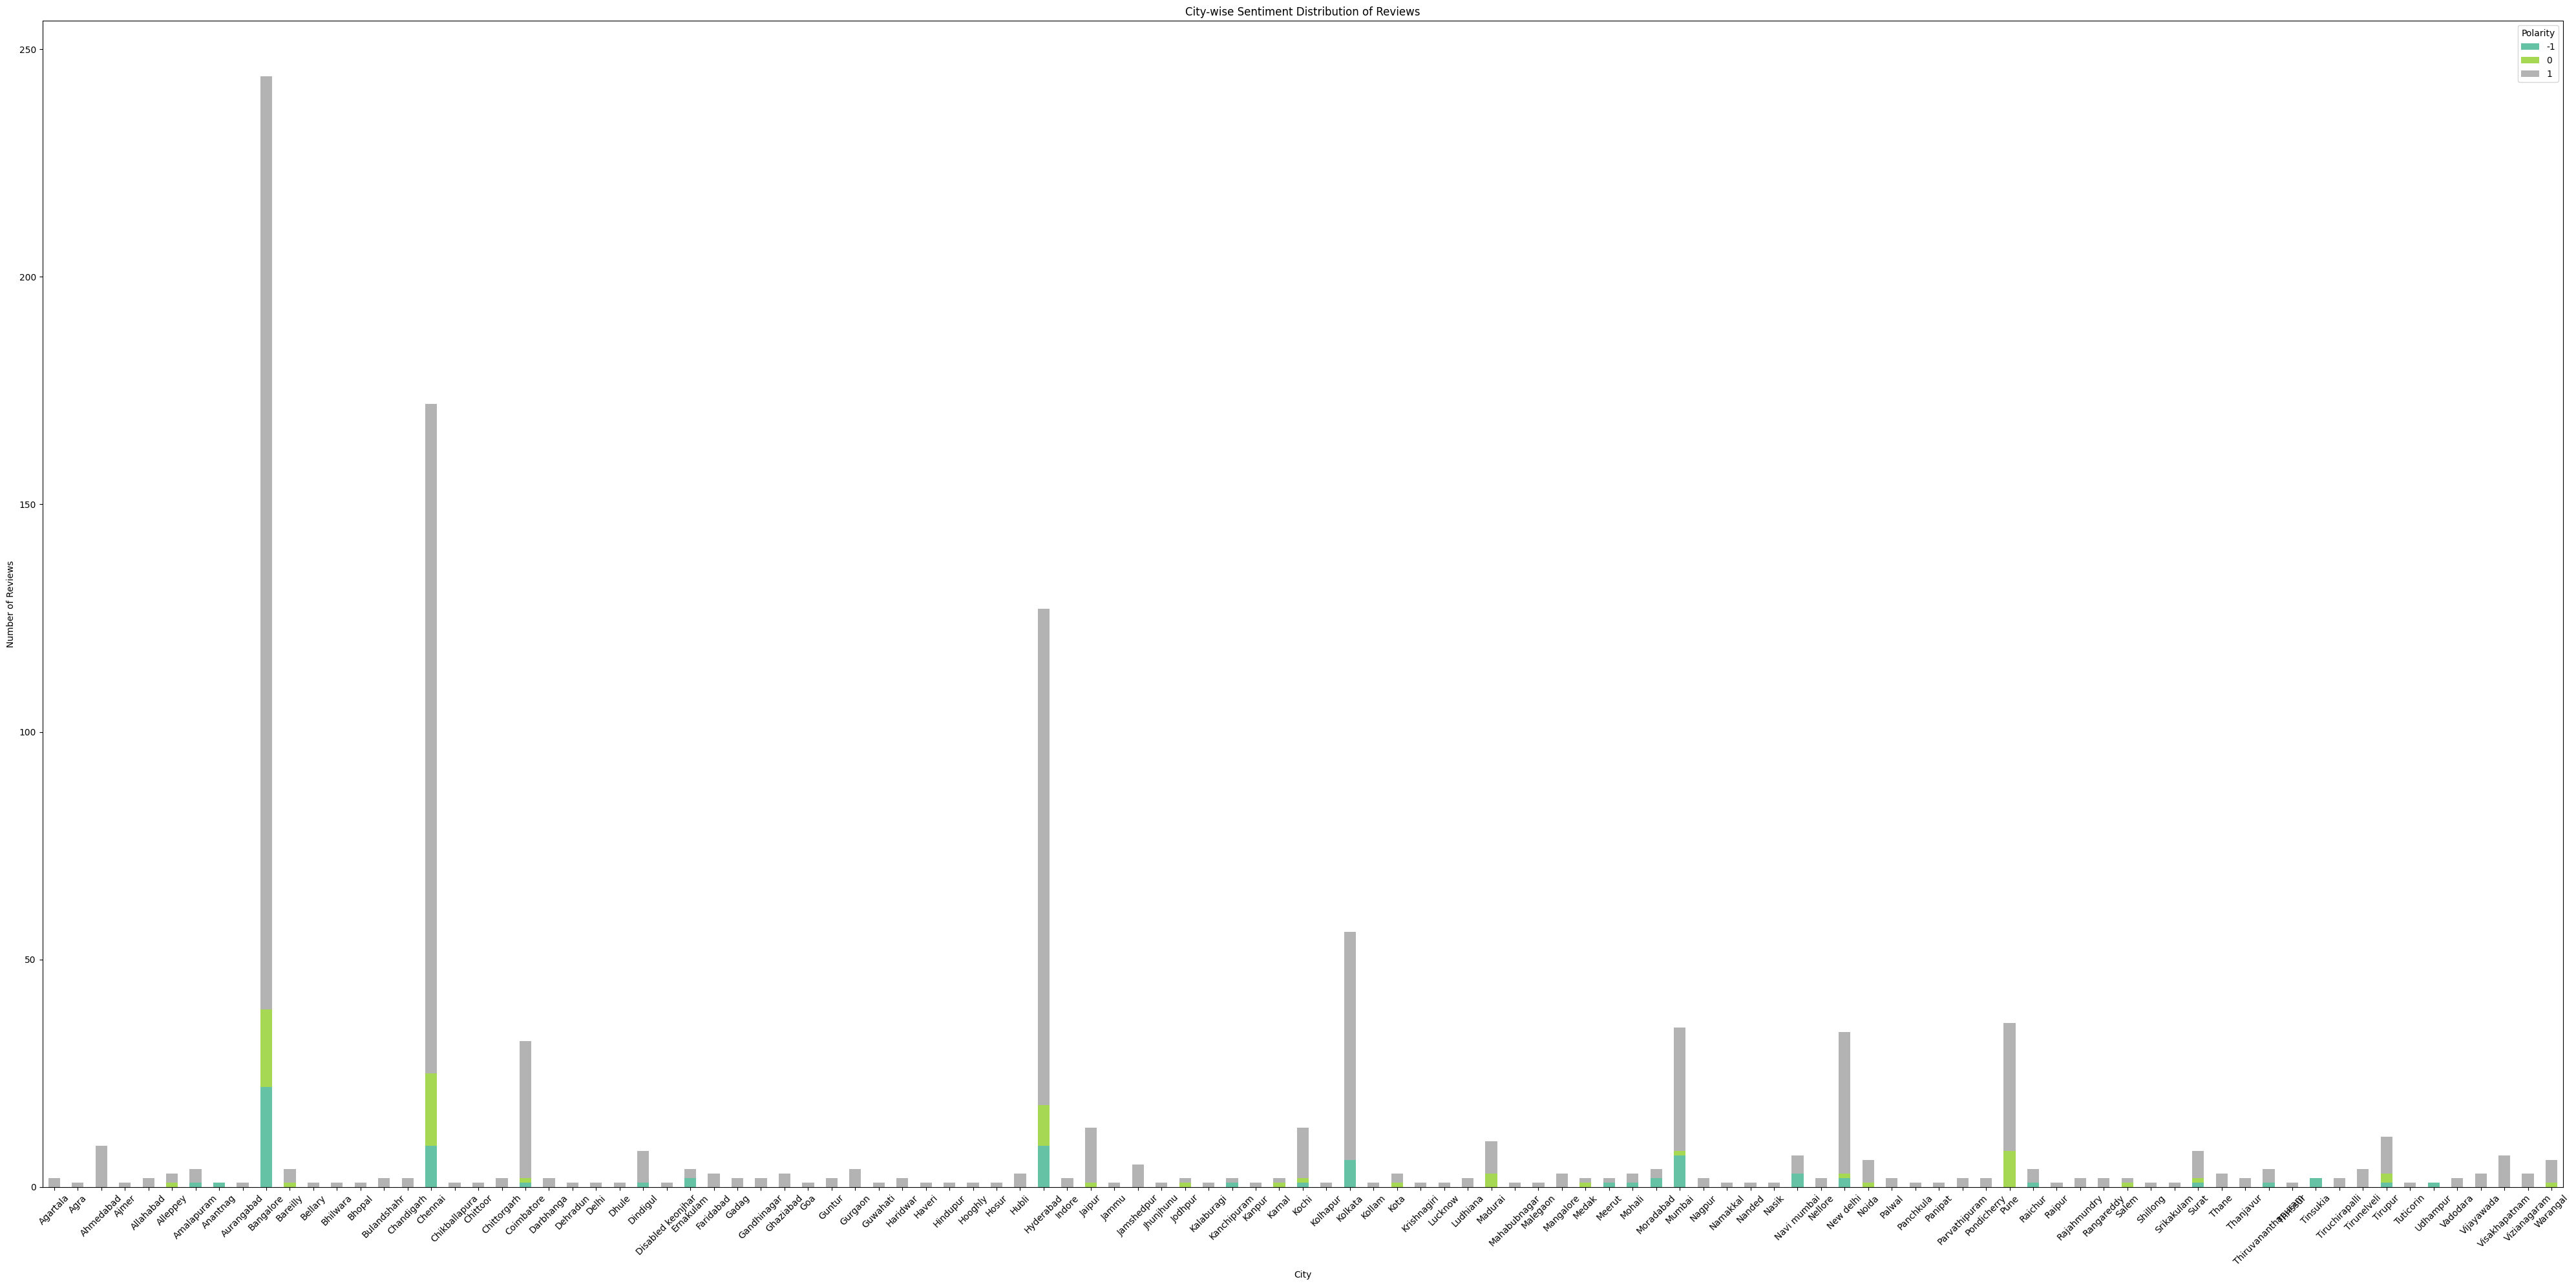

In [41]:
city_sentiment_counts = df.groupby(['Address', 'Polarity']).size().unstack(fill_value=0)

print(city_sentiment_counts)

# Stacked bar chart
city_sentiment_counts.plot(kind='bar', stacked=True, figsize=(40, 20), colormap='Set2')
plt.title('City-wise Sentiment Distribution of Reviews')
plt.xlabel('City')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

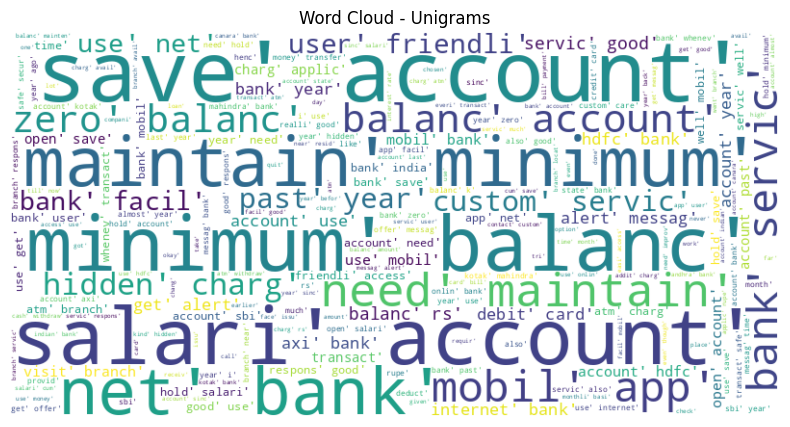

/tmp/ipython-input-42-2620335900.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_uni, x='frequency', y='word', palette='magma')


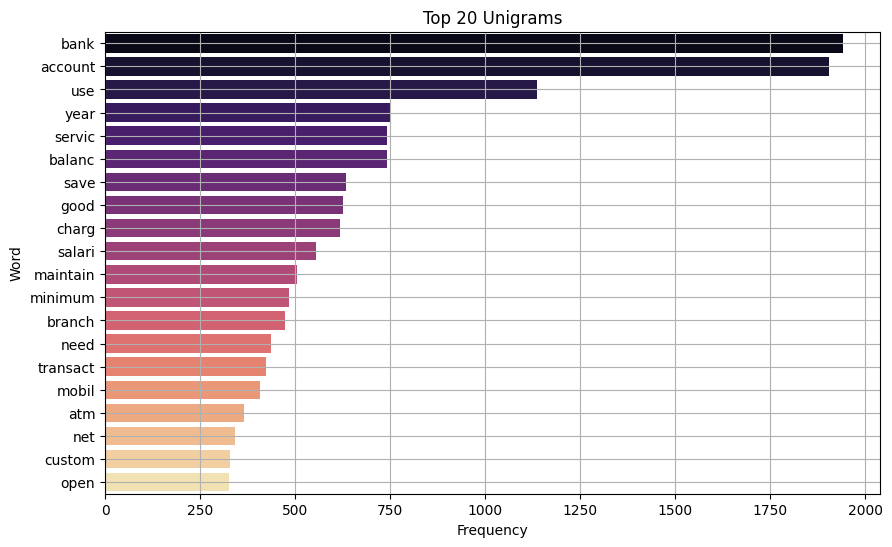

In [42]:
comments = df['Review'].dropna().astype(str)

text_all = " ".join(comments)

# Word Cloud for Unigrams
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(text_all)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Unigrams')
plt.show()

# Bar Chart - Top 20 Unigrams
vectorizer_uni = CountVectorizer(stop_words='english', max_features=20)
X_uni = vectorizer_uni.fit_transform(comments)
words = vectorizer_uni.get_feature_names_out()
counts = X_uni.sum(axis=0).A1
df_uni = pd.DataFrame({'word': words, 'frequency': counts}).sort_values(by='frequency', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_uni, x='frequency', y='word', palette='magma')
plt.title('Top 20 Unigrams')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.grid(True)
plt.show()

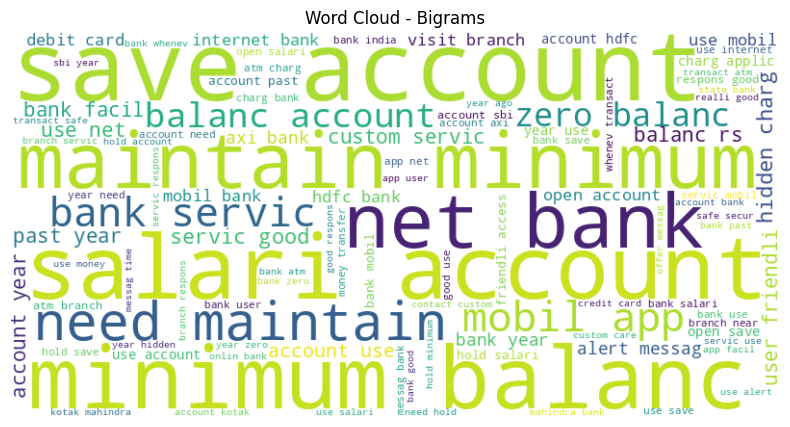

/tmp/ipython-input-43-4148472810.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_bi, x='frequency', y='bigram', palette='magma')


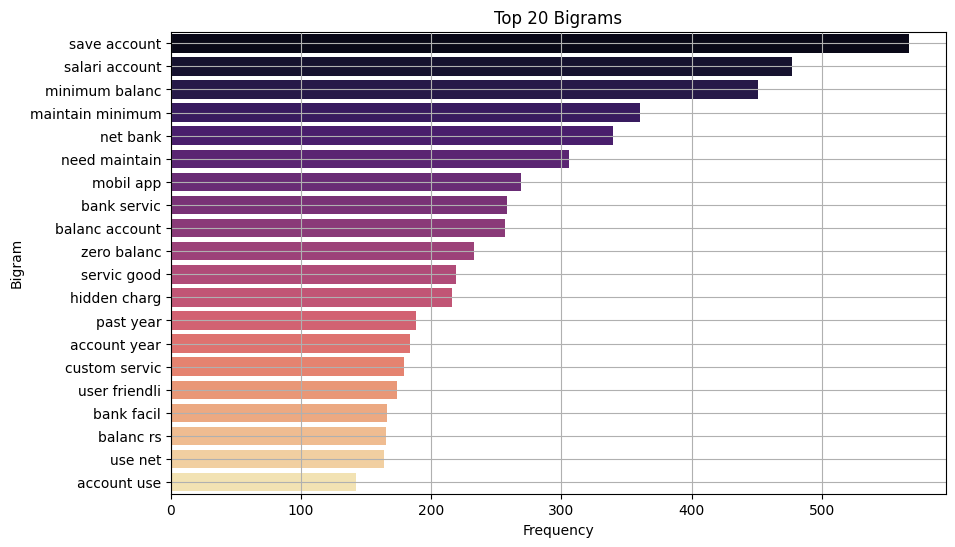

In [43]:
# Word Cloud for Bigrams
vectorizer_bi = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=100)
X_bi = vectorizer_bi.fit_transform(comments)
bigrams = vectorizer_bi.get_feature_names_out()
counts_bi = X_bi.sum(axis=0).A1
text_bigrams = dict(zip(bigrams, counts_bi))
wordcloud_bi = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(text_bigrams)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bi, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Bigrams')
plt.show()

# Bar Chart - Top 20 Bigrams
df_bi = pd.DataFrame({'bigram': bigrams, 'frequency': counts_bi}).sort_values(by='frequency', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_bi, x='frequency', y='bigram', palette='magma')
plt.title('Top 20 Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.grid(True)
plt.show()

/tmp/ipython-input-44-2927877431.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=freq_df, x='frequency', y='word', palette='viridis')


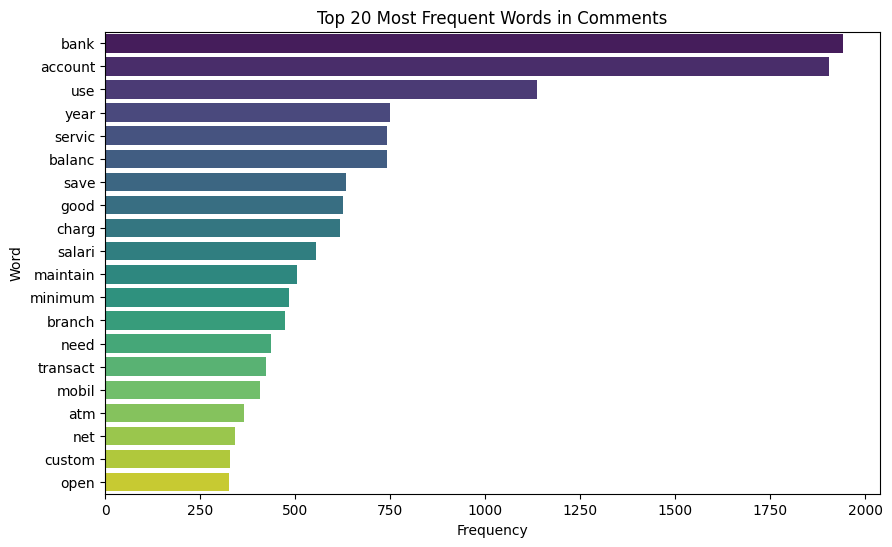

In [44]:
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['Review'].dropna().astype(str))
word_freq = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

freq_df = pd.DataFrame({'word': words, 'frequency': word_freq})
freq_df = freq_df.sort_values(by='frequency', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=freq_df, x='frequency', y='word', palette='viridis')
plt.title('Top 20 Most Frequent Words in Comments')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


#### Bag of Words

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(stop_words='english', max_features=100)
X_bow = bow_vectorizer.fit_transform(df['Review'].astype(str))

print(f"BoW Shape: {X_bow.shape}")
print("BoW - Top 10 Features:")
print(bow_vectorizer.get_feature_names_out()[:10])

BoW Shape: (999, 100)
BoW - Top 10 Features:
['access' 'account' 'ago' 'alert' 'app' 'applic' 'atm' 'avail' 'axi'
 'balanc']


#### TF-IDF vectorization

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

df['Review'] = df['Review'].astype(str)

# TF-IDF Vectorization with unigrams (1-grams)
vectorizer_unigram = TfidfVectorizer(ngram_range=(1, 1), stop_words='english', max_features=100)
X_unigram = vectorizer_unigram.fit_transform(df['Review'])

print("Top 10 Unigram Features:")
print(vectorizer_unigram.get_feature_names_out()[:10])

# TF-IDF Vectorization with bigrams (2-grams)
vectorizer_bigram = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', max_features=100)
X_bigram = vectorizer_bigram.fit_transform(df['Review'])

print("\nTop 10 Bigram Features:")
print(vectorizer_bigram.get_feature_names_out()[:10])

# TF-IDF Vectorization with both unigrams and bigrams (1-2 grams)
vectorizer_1_2gram = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=100)
X_1_2gram = vectorizer_1_2gram.fit_transform(df['Review'])

print(f"\nTF-IDF Shape: {X_1_2gram.shape}")
print("Top 10 1-2 Gram Features:")
print(vectorizer_1_2gram.get_feature_names_out()[:10])

Top 10 Unigram Features:
['access' 'account' 'ago' 'alert' 'app' 'applic' 'atm' 'avail' 'axi'
 'balanc']

Top 10 Bigram Features:
['account axi' 'account bank' 'account hdfc' 'account kotak'
 'account need' 'account past' 'account sbi' 'account use' 'account year'
 'alert messag']

TF-IDF Shape: (999, 100)
Top 10 1-2 Gram Features:
['access' 'account' 'account hdfc' 'account past' 'account sbi'
 'account use' 'account year' 'alert' 'alert messag' 'app']


#### Word2Vec Embeddings with Gensim

In [47]:
# Preprocess and tokenize the reviews
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

# Apply preprocessing
tokenized_reviews = df['Review'].apply(preprocess_text)

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_reviews,
                     vector_size=100,
                     window=5,
                     min_count=2,
                     workers=4,
                     sg=1)

word_vec = w2v_model.wv['account']
print("Vector for 'account':", word_vec[:10])

print("\nTop 5 words similar to 'loan':")
w2v_model.wv.most_similar('loan', topn=5)

Vector for 'account': [-0.07943062  0.07001998 -0.03321758  0.23024869  0.05533829 -0.5007937
  0.10854464  0.364876   -0.2752175  -0.2823568 ]

Top 5 words similar to 'loan':


[('sent', 0.9881669878959656),
 ('lost', 0.9833158850669861),
 ('number', 0.9828843474388123),
 ('intern', 0.9812642335891724),
 ('upgrad', 0.9807623624801636)]

In [48]:
def get_avg_vector(tokens, model):
    vec = np.zeros(model.vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count != 0 else vec


review_vectors = tokenized_reviews.apply(lambda x: get_avg_vector(x, w2v_model))
review_vectors_matrix = np.vstack(review_vectors.values)

print("\nShape of Word2Vec review matrix:", review_vectors_matrix.shape)


Shape of Word2Vec review matrix: (999, 100)


#### Glove embedding

In [49]:
import gensim.downloader as api

In [50]:
glove = api.load("glove-wiki-gigaword-100")

def get_avg_glove_vector(text):
    if isinstance(text, list):
        text = ' '.join(text)
    words = word_tokenize(text.lower())
    vectors = [glove[w] for w in words if w in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

embeddings = df['Review'].fillna('').apply(get_avg_glove_vector)
X_glove = np.vstack(embeddings.values)

print(f"GloVe Embedding Shape: {X_glove.shape}")


[==================================================] 100.0% 128.1/128.1MB downloaded
GloVe Embedding Shape: (999, 100)


####  VADER (Valence Aware Dictionary for Sentiment Reasoning)

In [51]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

df_og['vader_sentiment'] = df_og['Review'].apply(lambda x: vader.polarity_scores(str(x))['compound'])

# Label sentiment
df_og['vader_label'] = df_og['vader_sentiment'].apply(
    lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral'
)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [52]:
print(df_og['vader_label'].value_counts())

vader_label
positive    728
negative    212
neutral      59
Name: count, dtype: int64


#### TextBlob

In [53]:
from textblob import TextBlob

df_og['textblob_polarity'] = df_og['Review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df_og['textblob_subjectivity'] = df_og['Review'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

df_og['textblob_label'] = df_og['textblob_polarity'].apply(
    lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral'
)

In [54]:
print(df_og['textblob_label'].value_counts())

textblob_label
positive    767
neutral     192
negative     40
Name: count, dtype: int64


#### spaCy (via TextBlob)

In [55]:
import spacy
nlp = spacy.load('en_core_web_sm')

def spacy_textblob_sentiment(text):
    doc = nlp(str(text))
    blob = TextBlob(doc.text)
    return blob.sentiment.polarity

df_og['spacy_textblob_polarity'] = df_og['Review'].apply(spacy_textblob_sentiment)

df_og['spacy_label'] = df_og['spacy_textblob_polarity'].apply(
    lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral'
)

In [56]:
print(df_og['spacy_label'].value_counts())

spacy_label
positive    767
neutral     192
negative     40
Name: count, dtype: int64


### Comparison of VADER, TextBlob and spaCy

In [57]:
sample = df_og[['Review', 'vader_label', 'textblob_label', 'spacy_label']].sample(10, random_state=42)
print("Sample Sentiment Comparison:\n")
sample

Sample Sentiment Comparison:



,Review,vader_label,textblob_label,spacy_label
453,DBS Bank service is very good and I have bee...,positive,positive,positive
793,Opened my savings account from State bank of I...,negative,positive,positive
209,I am using salary account with Vijaya bank for...,positive,positive,positive
309,I have been using saving account from AXIS ban...,negative,neutral,neutral
740,I have Axis Bank saving account for the past 5...,positive,positive,positive
578,Its been one year with Axis Bank and their int...,positive,positive,positive
895,I have HDFC Bank Salary account which i am usi...,positive,positive,positive
545,Standard Chartered bank is providing good serv...,positive,positive,positive
436,5 months ago took the savings account from Kot...,positive,positive,positive
678,"Around 2014, i have opened the savings account...",positive,positive,positive


In [58]:
print("\nSentiment Distribution:")
print("\nVADER:\n", df_og['vader_label'].value_counts())
print("\nTextBlob:\n", df_og['textblob_label'].value_counts())
print("\nspaCy+TextBlob:\n", df_og['spacy_label'].value_counts())


Sentiment Distribution:

VADER:
 vader_label
positive    728
negative    212
neutral      59
Name: count, dtype: int64

TextBlob:
 textblob_label
positive    767
neutral     192
negative     40
Name: count, dtype: int64

spaCy+TextBlob:
 spacy_label
positive    767
neutral     192
negative     40
Name: count, dtype: int64


In [59]:
def categorize_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'


In [60]:
df_og['vader_sentiment'] = df_og['vader_sentiment'].apply(categorize_sentiment)
df_og['textblob_polarity'] = df_og['textblob_polarity'].apply(categorize_sentiment)
df_og['spacy_textblob_polarity'] = df_og['spacy_textblob_polarity'].apply(categorize_sentiment)


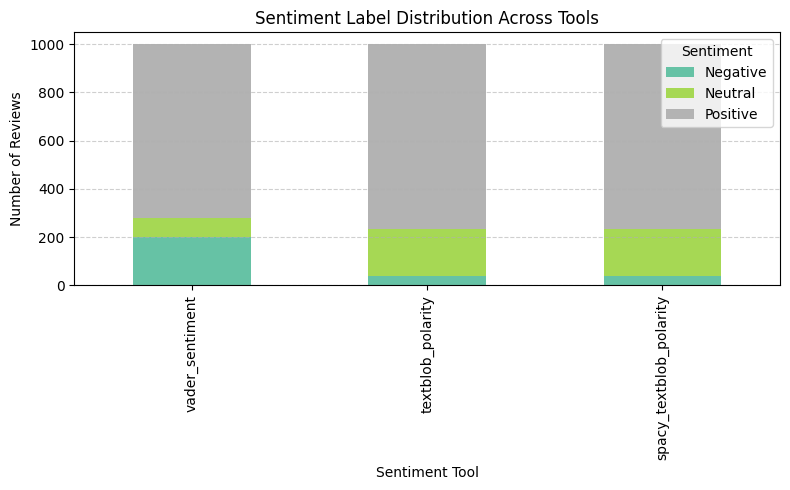

In [61]:
label_df = df_og[['vader_sentiment', 'textblob_polarity', 'spacy_textblob_polarity']]
label_counts = label_df.apply(pd.Series.value_counts).T.fillna(0)

label_counts.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='Set2')
plt.title('Sentiment Label Distribution Across Tools')
plt.ylabel('Number of Reviews')
plt.xlabel('Sentiment Tool')
plt.legend(title='Sentiment')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [62]:
df_og['vader_score'] = df_og['Review'].apply(lambda x: vader.polarity_scores(x)['compound'])
df_og['textblob_score'] = df_og['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_og['spacy_score'] = df_og['Review'].apply(lambda x: TextBlob(nlp(x).text).sentiment.polarity)

In [63]:
def get_label(score, pos_thres=0.1, neg_thres=-0.1):
    if score >= pos_thres:
        return 'positive'
    elif score <= neg_thres:
        return 'negative'
    else:
        return 'neutral'

df_og['vader_label'] = df_og['vader_score'].apply(get_label)
df_og['textblob_label'] = df_og['textblob_score'].apply(get_label)
df_og['spacy_label'] = df_og['spacy_score'].apply(get_label)

# Identify disagreement cases
df_og['disagreement'] = df_og.apply(
    lambda row: len(set([row['vader_label'], row['textblob_label'], row['spacy_label']])) > 1,
    axis=1
)

# Extract and view disagreement samples
disagreements = df_og[df_og['disagreement'] == True]
print("Number of disagreements:", len(disagreements))

sample_disagreements = disagreements[['Review', 'vader_label', 'textblob_label', 'spacy_label']].sample(5, random_state=42)
sample_disagreements



Number of disagreements: 315


,Review,vader_label,textblob_label,spacy_label
662,I have SBI saving account which i am using for...,positive,neutral,neutral
104,I am holding salary account with HDFC past 1 y...,negative,neutral,neutral
546,I am having a savings account from HDFC and wh...,negative,neutral,neutral
251,"On twelve years before, I have opened the savi...",negative,positive,positive
307,"From past 2 years, i have been using my salary...",negative,neutral,neutral


In [64]:
summary = pd.DataFrame({
    'Agree': [len(df) - len(disagreements)],
    'Disagree': [len(disagreements)]
})
print("\nAgreement Summary:")
summary


Agreement Summary:


,Agree,Disagree
0,684,315


### Modeling

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import ast
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Logistic Regression and Naive Bayes

In [74]:
df['Review'] = df['Review'].apply(
    lambda x: ' '.join(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x
)


X = df['Review']
y = df['Polarity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_tfidf, y_train)

# Train
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_tfidf, y_train)

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)


# Predict
y_pred_log = log_reg.predict(X_test_tfidf)
y_pred_nb = nb.predict(X_test_tfidf)

# Evaluation
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_log))

print("\nNaive Bayes Results:")
print(classification_report(y_test, y_pred_nb))



Logistic Regression Results:
              precision    recall  f1-score   support

          -1       0.20      0.13      0.16        15
           0       0.11      0.14      0.12        14
           1       0.89      0.89      0.89       171

    accuracy                           0.79       200
   macro avg       0.40      0.39      0.39       200
weighted avg       0.78      0.79      0.78       200


Naive Bayes Results:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        15
           0       0.00      0.00      0.00        14
           1       0.85      1.00      0.92       171

    accuracy                           0.85       200
   macro avg       0.28      0.33      0.31       200
weighted avg       0.73      0.85      0.79       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


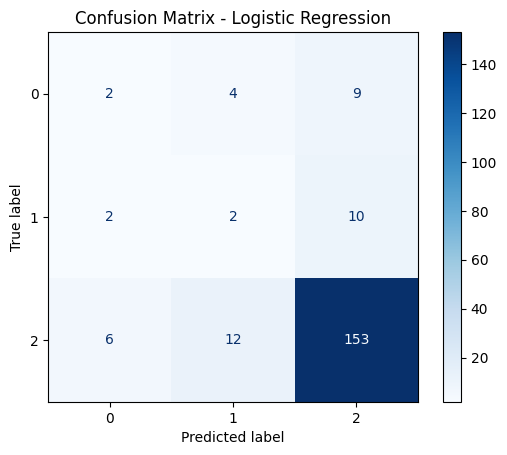

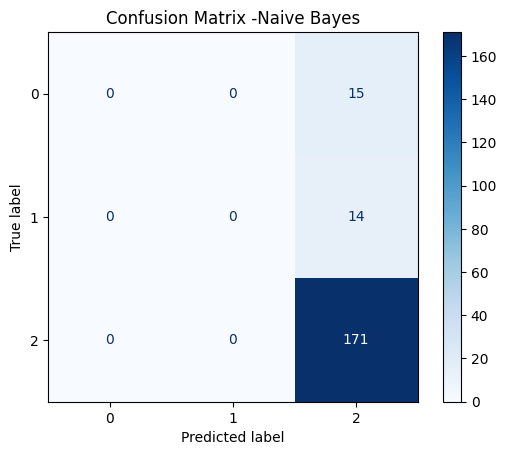

In [75]:

# Confusion matrix for logistic regression
cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Confusion matrix for naive bayes
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix -Naive Bayes")
plt.show()

### LSTM

In [76]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [80]:
# Encode labels: -1 → 0, 0 → 1, 1 → 2
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Random oversampling on raw text
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(np.array(X).reshape(-1, 1), y_enc)
X_resampled = X_resampled.flatten()

# Train-test split
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# One-hot encode targets
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Train Word2Vec embeddings on tokenized training data
tokenized = [word_tokenize(text.lower()) for text in X_train]
w2v_model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=2, workers=4)

# Create embedding matrix
embedding_dim = 100
vocab_size = 10000
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Build model
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=True
))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

# Compile with lower learning rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=5e-4),
    metrics=['accuracy']
)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_pad,
    y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
y_pred = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_.astype(str)))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 267ms/step - accuracy: 0.3749 - loss: 1.0930 - val_accuracy: 0.4688 - val_loss: 1.0577
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 423ms/step - accuracy: 0.4531 - loss: 1.0435 - val_accuracy: 0.5098 - val_loss: 0.9832
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 350ms/step - accuracy: 0.5289 - loss: 0.9681 - val_accuracy: 0.5801 - val_loss: 0.8880
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 310ms/step - accuracy: 0.6253 - loss: 0.8590 - val_accuracy: 0.6191 - val_loss: 0.8137
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 391ms/step - accuracy: 0.6949 - loss: 0.7127 - val_accuracy: 0.7305 - val_loss: 0.6205
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 325ms/step - accuracy: 0.8013 - loss: 0.5340 - val_accuracy: 0.8398 - val_loss: 0.4323
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - accuracy: 0.8478 - loss: 0.4120 - val_accuracy: 0.8633 - val_loss: 0.3866
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.8730 - loss: 0.3377 - val_accu

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Classification Report:
              precision    recall  f1-score   support

          -1       0.92      0.99      0.95       170
           0       0.96      0.88      0.92       171
           1       0.87      0.88      0.88       171

    accuracy                           0.92       512
   macro avg       0.92      0.92      0.92       512
weighted avg       0.92      0.92      0.92       512

Accuracy: 0.9160


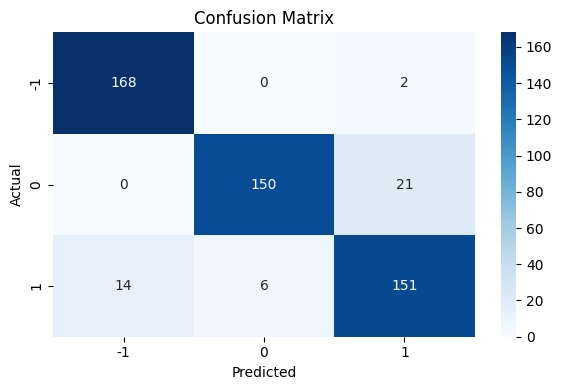

In [81]:
y_pred_prob = model.predict(X_test_pad)

# Convert probabilities to predicted classes
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels (already encoded to 0, 1, 2)
y_true = y_test_enc

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_.astype(str)))

# Accuracy Score
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


### DistilBERT

In [83]:
# Encode labels from 'Polarity'
le = LabelEncoder()
df['label'] = le.fit_transform(df['Polarity'])

# Apply RandomOverSampler on raw reviews
ros = RandomOverSampler(random_state=42)
text_resampled, label_resampled = ros.fit_resample(
    np.array(df['Review']).reshape(-1, 1), df['label']
)

# Create a balanced DataFrame
df_balanced = pd.DataFrame({'Review': text_resampled.flatten(), 'label': label_resampled})


In [84]:
import transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['Polarity'])

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['Review'].tolist(), df_balanced['label'].tolist(), test_size=0.2, random_state=42
)

# Load tokenizer and encode data
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_dict({**train_encodings, 'label': train_labels})
val_dataset = Dataset.from_dict({**val_encodings, 'label': val_labels})

# Load pre-trained model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Evaluate
eval_result = trainer.evaluate()
print("\nEvaluation Results:", eval_result)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: madhu216121 (madhu216121-indian-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,1.086200
20,1.117100
30,1.097700
40,1.091500
50,1.066700
60,1.059900
70,1.117200
80,1.045700
90,0.954900
100,0.893600


Step,Training Loss
10,1.086200
20,1.117100
30,1.097700
40,1.091500
50,1.066700
60,1.059900
70,1.117200
80,1.045700
90,0.954900
100,0.893600



Evaluation Results: {'eval_loss': 0.09577496349811554, 'eval_runtime': 94.6411, 'eval_samples_per_second': 5.41, 'eval_steps_per_second': 0.338, 'epoch': 3.0}


In [85]:
preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=1)

print("DistilBERT:\n", classification_report(val_labels, preds))

DistilBERT:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       186
           1       0.97      1.00      0.98       164
           2       0.99      0.94      0.97       162

    accuracy                           0.98       512
   macro avg       0.98      0.98      0.98       512
weighted avg       0.98      0.98      0.98       512



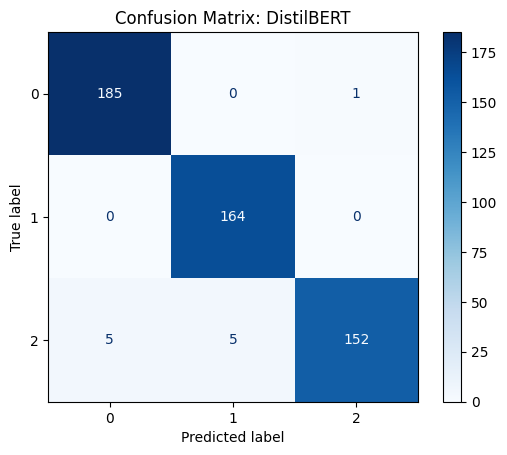

In [96]:
# confusion matrix
cm = confusion_matrix(val_labels, preds)
labels = np.unique(np.concatenate([val_labels, preds]))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: DistilBERT")
plt.show()

### Comparison of Models

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-98-3773402533.py:21: FutureWar

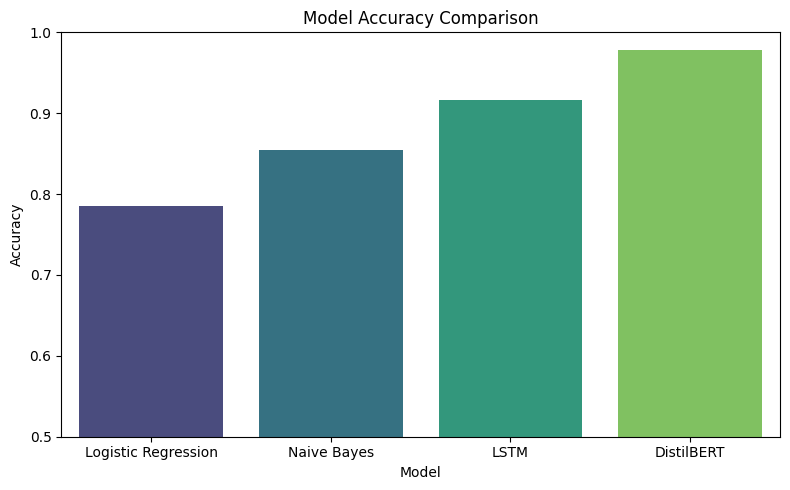

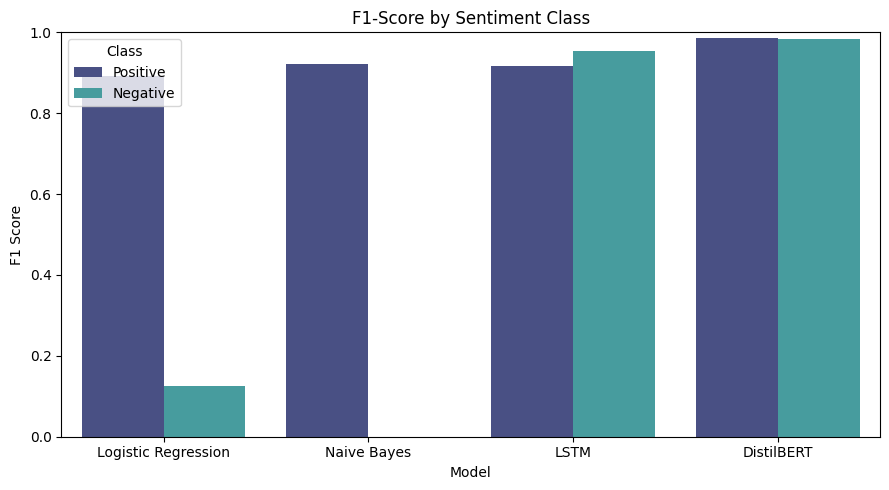

In [98]:
def get_scores(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        'model': model_name,
        'accuracy': report['accuracy'],
        'f1_positive': report['1']['f1-score'],
        'f1_negative': report['0']['f1-score']
    }

results = []
results.append(get_scores(y_test, y_pred_log, 'Logistic Regression'))
results.append(get_scores(y_test, y_pred_nb, 'Naive Bayes'))
results.append(get_scores(y_true_labels, y_pred_labels, 'LSTM'))
results.append(get_scores(val_labels, preds, 'DistilBERT'))

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Accuracy Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='model', y='accuracy', data=results_df, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylim(0.5, 1.0)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

# F1-Score per Class
f1_df = results_df.melt(id_vars='model', value_vars=['f1_positive', 'f1_negative'], var_name='class', value_name='f1_score')
f1_df['class'] = f1_df['class'].map({'f1_positive': 'Positive', 'f1_negative': 'Negative'})

plt.figure(figsize=(9, 5))
sns.barplot(x='model', y='f1_score', hue='class', data=f1_df, palette='mako')
plt.title("F1-Score by Sentiment Class")
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.legend(title='Class')
plt.tight_layout()
plt.show()


### Top complaint themes

/tmp/ipython-input-87-82097.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['Review'].apply(preprocess)
/tmp/ipython-input-87-82097.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=top_df, palette='rocket')


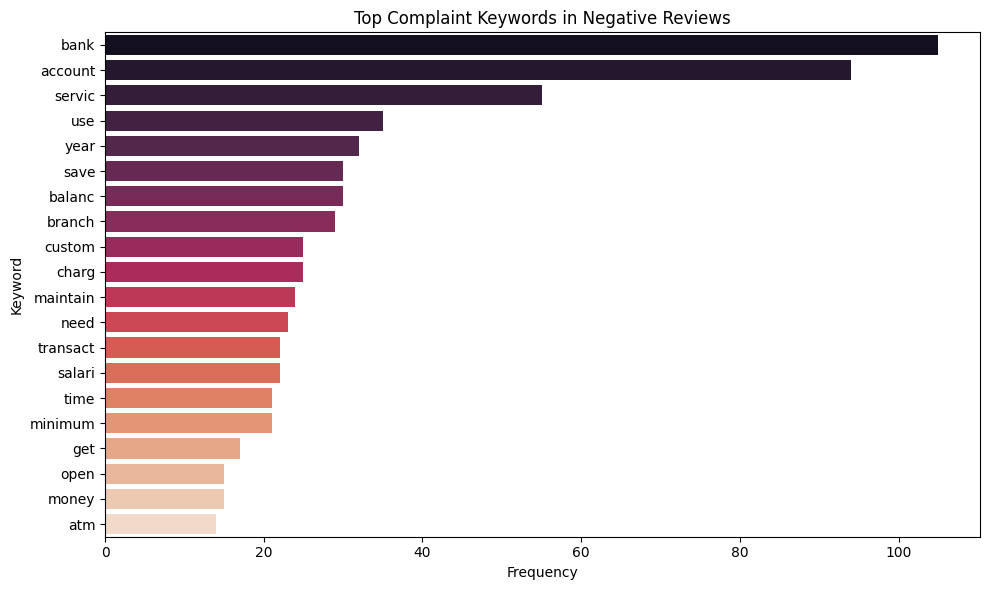

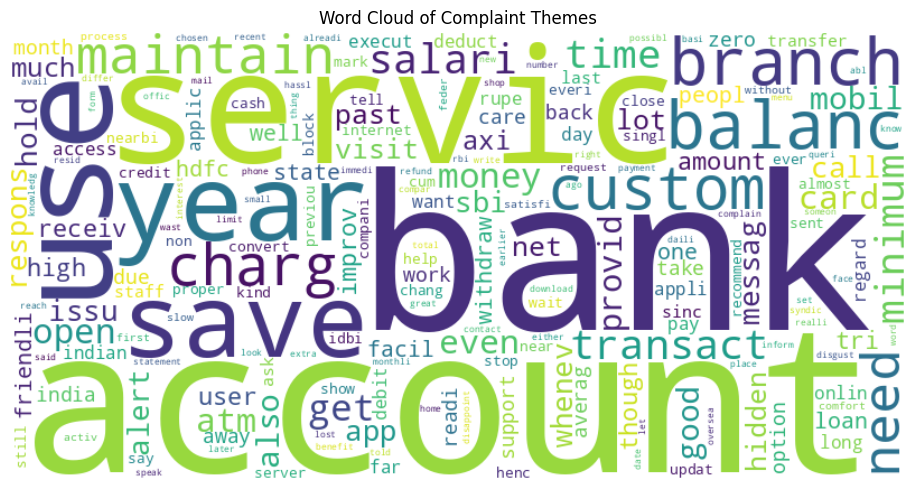


Top Complaint Bigrams:
save account: 26
minimum balanc: 20
salari account: 19
maintain minimum: 16
bank servic: 15
need maintain: 12
custom servic: 10
hidden charg: 9
net bank: 9
past year: 9


In [87]:
def get_sentiment(r):
    if r >= 4:
        return 'positive'
    elif r <= 2:
        return 'negative'
    else:
        return None

df['Polarity'] = df['Rating'].apply(get_sentiment)
df = df[df['Polarity'] == 'negative']

# Clean and tokenize
def preprocess(text):
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    return [word for word in tokens if word not in stopwords.words('english') and len(word) > 2]

df['tokens'] = df['Review'].apply(preprocess)

# Flatten all tokens into a single list
all_tokens = [word for tokens in df['tokens'] for word in tokens]

# Get most common words
word_counts = Counter(all_tokens)
top_words = word_counts.most_common(20)

# Convert to DataFrame for plotting
top_df = pd.DataFrame(top_words, columns=['word', 'count'])

# Bar Plot of Top Keywords
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=top_df, palette='rocket')
plt.title('Top Complaint Keywords in Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.tight_layout()
plt.show()

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Complaint Themes")
plt.tight_layout()
plt.show()

# Bigram Analysis
bigrams = Counter(ngrams(all_tokens, 2))
top_bigrams = bigrams.most_common(10)
print("\nTop Complaint Bigrams:")
for phrase, count in top_bigrams:
    print(f"{' '.join(phrase)}: {count}")


### Aspect Based Sentiment Analysis

In [88]:
from collections import defaultdict

def get_sentiment(r):
    if r >= 4:
        return 'positive'
    elif r <= 2:
        return 'negative'
    else:
        return None

df['Polarity'] = df['Rating'].apply(get_sentiment)

# Define aspect keywords (you can expand this)
aspect_keywords = ['service', 'loan', 'card', 'charges', 'staff', 'app', 'transaction', 'support']

# ABSA function
def extract_aspects(text):
    doc = nlp(text)
    aspects = []
    for token in doc:
        if token.text in aspect_keywords:
            # Find nearby adjective or opinion
            window = doc[max(token.i - 3, 0): min(token.i + 4, len(doc))]
            sentiment_phrase = window.text
            polarity = TextBlob(sentiment_phrase).sentiment.polarity
            label = 'positive' if polarity > 0.1 else 'negative' if polarity < -0.1 else 'neutral'
            aspects.append({'aspect': token.text, 'opinion': sentiment_phrase, 'Polarity': label})
    return aspects

# Apply to a sample (or full dataset)
sample_reviews = df.sample(20, random_state=42)['Review']
all_aspects = []

for review in sample_reviews:
    aspects = extract_aspects(review)
    for asp in aspects:
        asp['Review'] = review
        all_aspects.append(asp)

# Convert to DataFrame
aspects_df = pd.DataFrame(all_aspects)
print("Extracted Aspect-Based Sentiment:")
aspects_df[['Review', 'aspect', 'opinion', 'Polarity']]

/tmp/ipython-input-88-1299001844.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Polarity'] = df['Rating'].apply(get_sentiment)


Extracted Aspect-Based Sentiment:


,Review,aspect,opinion,Polarity
0,hold save account kotak bank year whenev tri w...,app,amount use mobil app net bank user,neutral
1,hold indian oversea bank past year sinc govern...,support,bank servic custom support use mobil app,neutral
2,hold indian oversea bank past year sinc govern...,app,support use mobil app net bank user,neutral
3,idbi bank account benefit good henc rare use a...,app,account use mobil app facil branch respons,neutral
4,need lot improv guid custom tell visit branch ...,card,appli new debit card told lost card,positive
5,need lot improv guid custom tell visit branch ...,card,card told lost card someon tri access,neutral
6,need lot improv guid custom tell visit branch ...,card,block need replac card tell pay get,neutral
7,need lot improv guid custom tell visit branch ...,card,pay get new card get card use,positive
8,need lot improv guid custom tell visit branch ...,card,new card get card use account past,neutral
9,need lot improv guid custom tell visit branch ...,loan,year use servic loan credit card total,neutral


In [89]:
# Count by aspect
print("\nAspect Sentiment Counts:")
aspects_df.groupby(['aspect', 'Polarity']).size().unstack(fill_value=0)


Aspect Sentiment Counts:


Polarity,neutral,positive
aspect,,
app,3,0
card,4,2
loan,2,1
support,1,1


### Department level insights

In [90]:
department_keywords = {
    "loan process": ["loan", "loan process", "home loan", "personal loan"],
    "branch experience": ["branch", "staff", "manager", "in person"],
    "customer service": ["customer service", "support", "call", "response"],
    "account opening": ["account opening", "new account", "open account"],
    "mobile app": ["app", "application", "mobile", "online"],
    "charges/fees": ["charges", "fees", "hidden charge", "deduction"],
    "credit card": ["credit card", "card limit", "card issue"]
}

# Function to match and score sentiment
def extract_department_sentiments(text):
    sentiments = []
    for dept, keywords in department_keywords.items():
        for kw in keywords:
            if re.search(rf'\b{re.escape(kw)}\b', text):
                sentiment_score = TextBlob(text).sentiment.polarity
                label = 'positive' if sentiment_score > 0.1 else 'negative' if sentiment_score < -0.1 else 'neutral'
                sentiments.append((dept, kw, sentiment_score, label))
    return sentiments

# Apply to dataset
results = []

for _, row in df.iterrows():
    review = row['Review']
    matches = extract_department_sentiments(review)
    for dept, kw, score, label in matches:
        results.append({
            "department": dept,
            "matched_phrase": kw,
            "Review": review,
            "sentiment_score": score,
            "Polarity": label
        })

# Create DataFrame
insights_df = pd.DataFrame(results)

# View sample insights
print("Sample Department-Level Insights:")
insights_df.head(10)




Sample Department-Level Insights:


,department,matched_phrase,Review,sentiment_score,Polarity
0,branch experience,branch,axi bank limit option menu custom support mean...,-0.187500,negative
1,customer service,support,axi bank limit option menu custom support mean...,-0.187500,negative
2,customer service,call,axi bank limit option menu custom support mean...,-0.187500,negative
3,mobile app,app,axi bank limit option menu custom support mean...,-0.187500,negative
4,mobile app,app,hold save account sbi bank year hidden charg b...,-0.166667,negative
5,mobile app,app,salari account axi bank month back hidden char...,-0.083333,neutral
6,branch experience,branch,idbi bank account benefit good henc rare use a...,0.340000,positive
7,account opening,open account,idbi bank account benefit good henc rare use a...,0.340000,positive
8,mobile app,app,idbi bank account benefit good henc rare use a...,0.340000,positive
9,mobile app,app,bank server time render upi transact even open...,-0.083333,neutral


In [91]:
# Sentiment counts per department
summary = insights_df.groupby(['department', 'Polarity']).size().unstack(fill_value=0)
print("\nDepartment-Level Sentiment Summary:")
summary


Department-Level Sentiment Summary:


Polarity,negative,neutral,positive
department,,,
account opening,0,2,3
branch experience,2,11,11
credit card,0,2,0
customer service,3,5,4
loan process,1,2,2
mobile app,3,5,2


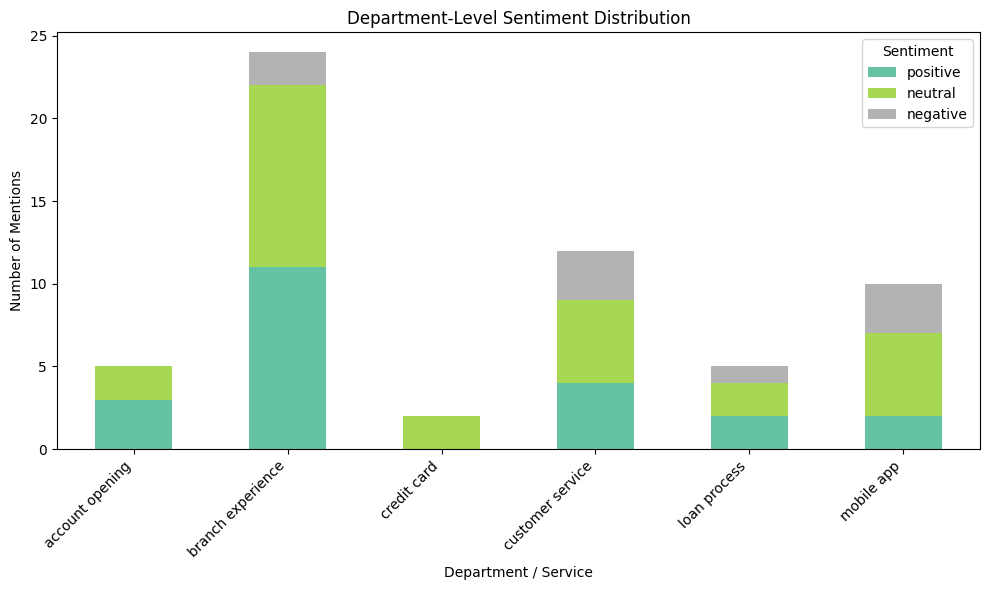

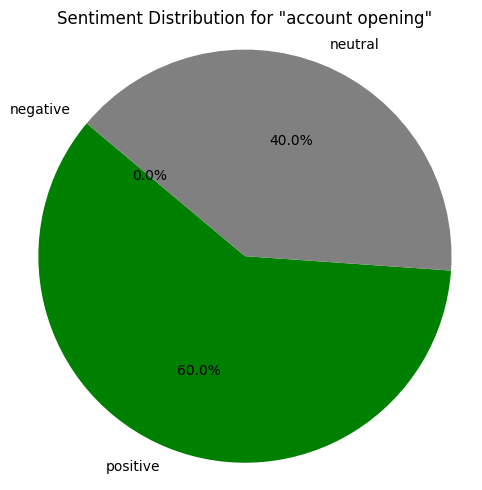

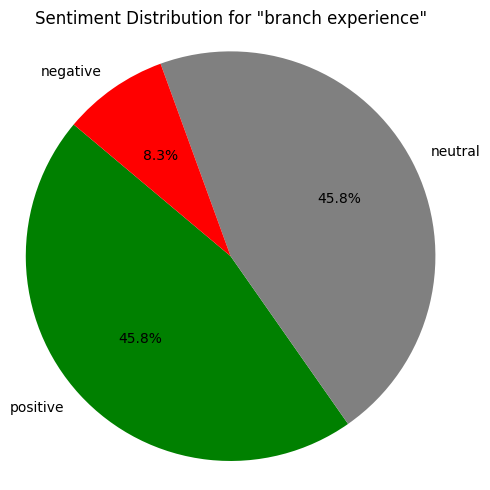

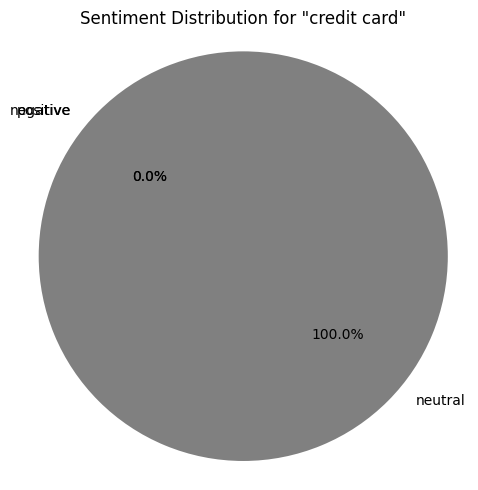

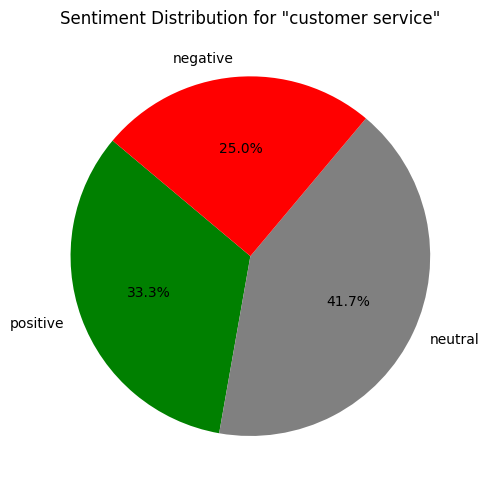

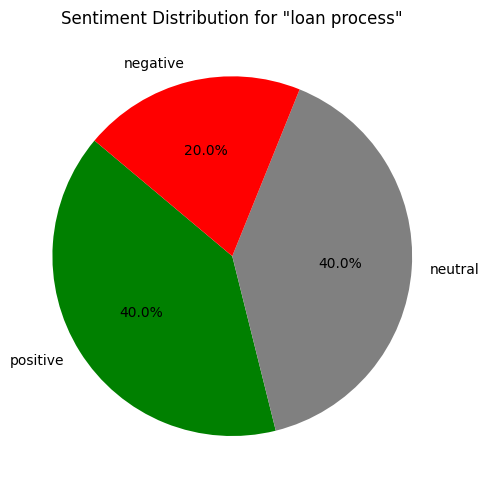

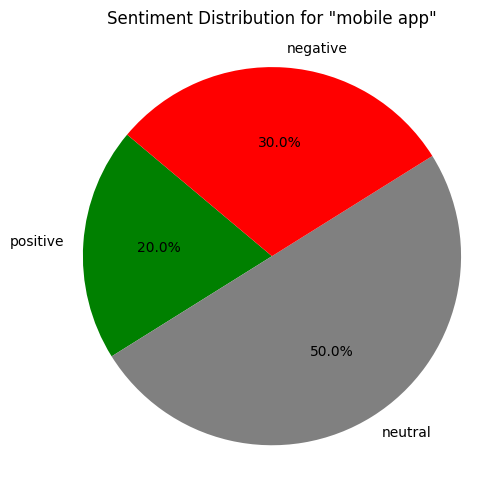

In [92]:
# Stacked Bar Chart: Sentiment Count per Department
summary = insights_df.groupby(['department', 'Polarity']).size().unstack(fill_value=0)
summary = summary[['positive', 'neutral', 'negative']]  # Consistent order

summary.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title('Department-Level Sentiment Distribution')
plt.xlabel('Department / Service')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Pie Chart for Each Department
for dept in summary.index:
    sentiment_counts = summary.loc[dept]
    plt.figure(figsize=(5, 5))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['green', 'gray', 'red'])
    plt.title(f'Sentiment Distribution for "{dept}"')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
